# Gemini API: Fine Tuning

In this notebook, we'll learn how to get started with the tuning service using the Python client library for the Gemini API. Here, we'll learn how to tune the text model behind the Gemini API's text generation service.

**Note**: At this time, tuning is only available for the `gemini-1.0-pro-001` model.

## Setup

### Authenticate

The Gemini API lets we tune models on your own data. Since it's your data and
your tuned models this needs stricter access controls than API-Keys can provide.

Before we can run this tutorial, we'll need to
[setup OAuth for your project](https://ai.google.dev/palm_docs/oauth_quickstart).


In Colab the easiest wat to get setup is to copy the contents of your `client_secret.json` file into Colab's "Secrets manager" (under the key icon in the left panel) with the secret name `CLIENT_SECRET`.

This gcloud command turns the `client_secret.json` file into credentials that can be used to authenticate with the service.

> Important: If we're running this in Colab, **don't just click the link it prints**. That will fail. Follow the instructions and copy the `gcloud` command it prints to your local machine and run it there, then paste the output from your local machine back here.



1. Create a google cloud project by following the instructions on [the page](https://developers.google.com/workspace/guides/create-project). If we have a Google project, we can skip this part.

2. After creating the project, complete the items 1, 2, 3 on [the page](https://ai.google.dev/palm_docs/oauth_quickstart) in order.



3. Please click [A local installation of the gcloud CLI](https://cloud.google.com/sdk/docs/install). And istall Google Cloud CLI.

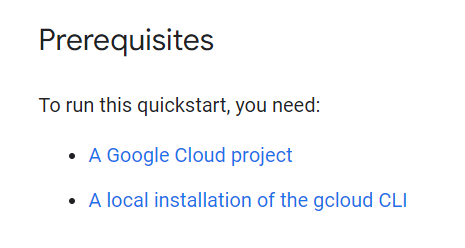

4. Click on the GoogleCloudSDKInstaller file from the downloads folder and setup it on your computer.

5. Open the Googlecloud Shell and enter the "gcloud init --skip-diagnostics" command and select number 2. Then press enter

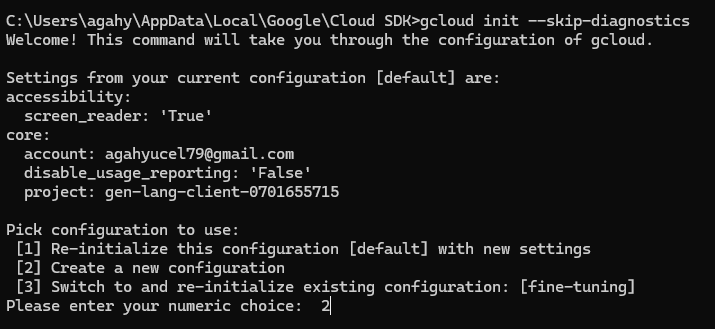



6. Enter the configuration name like "finetuning" etc.

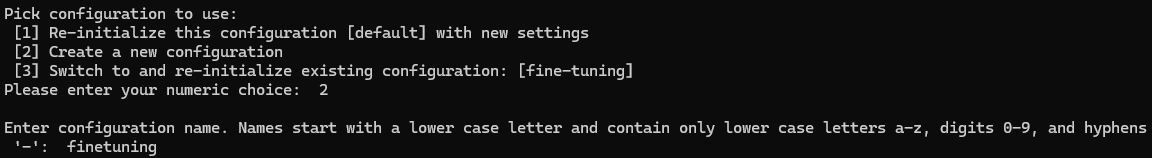


7. To log in, select user and project of "gen-lang-client-.."

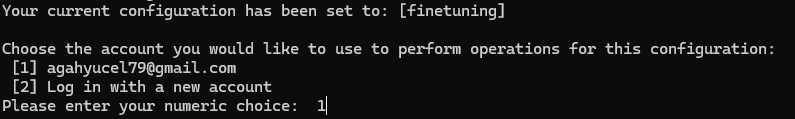

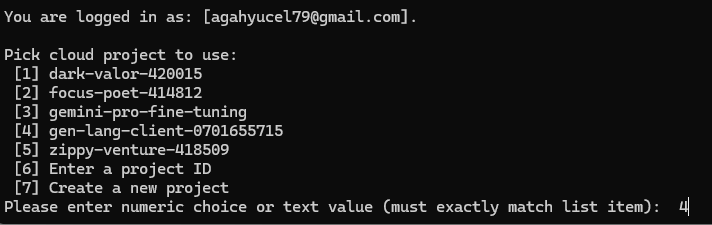

8. Select "no" for default compute region and zone

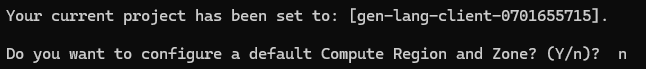

9. Download client_secret.json to your drive/local

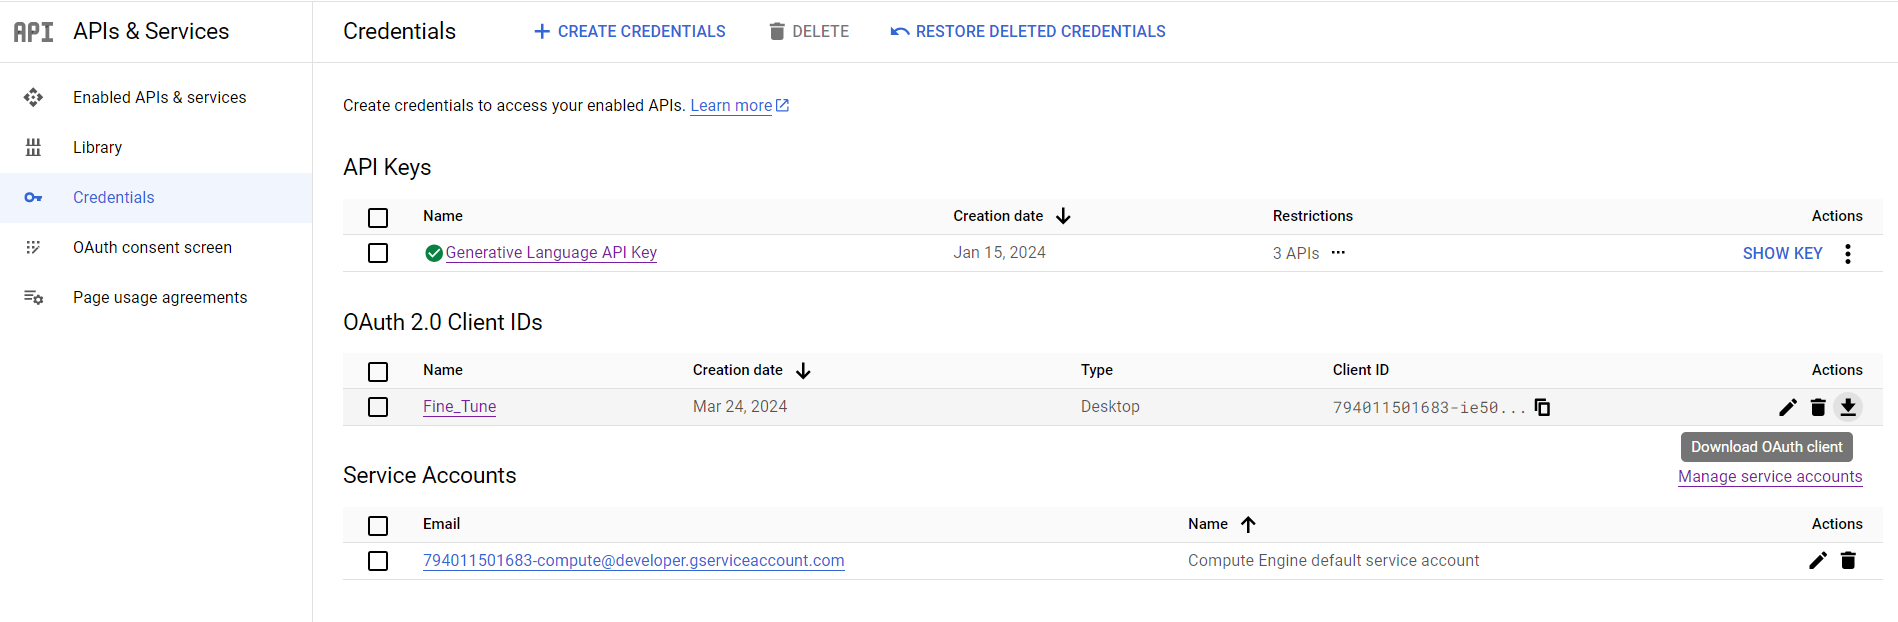

10. Install the json files to colab and rename as "client_secret.json"

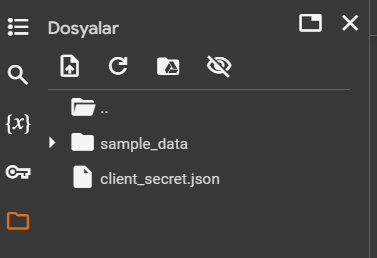

11. Select the second line into blue and past on Google Cloud SDK Shell Terminal. Then click enter
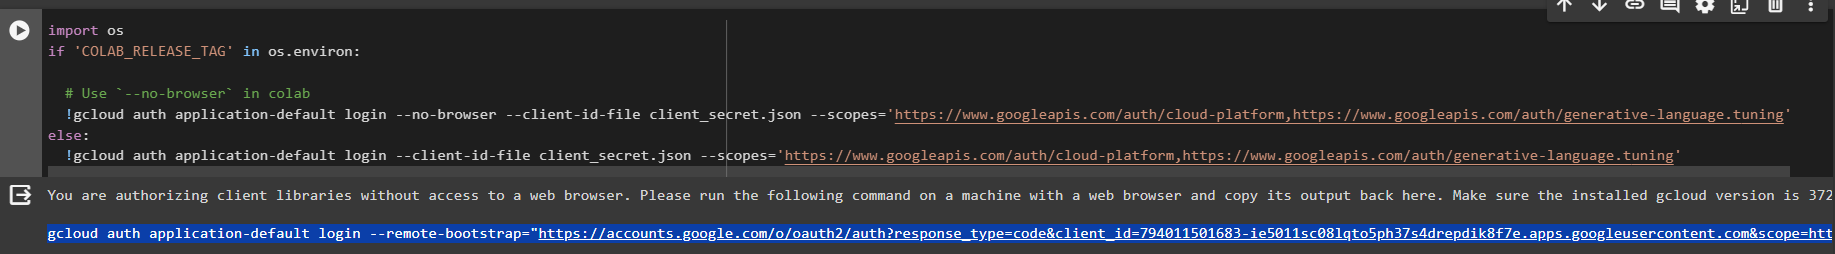

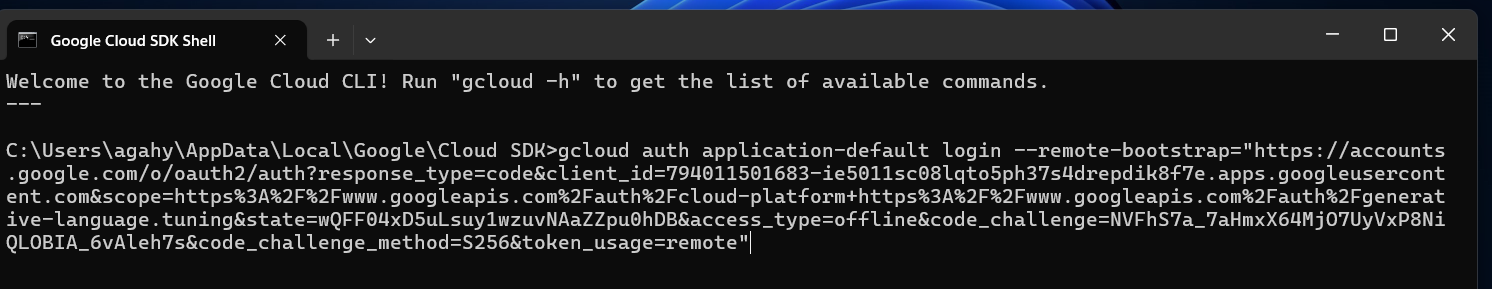

12. Click yes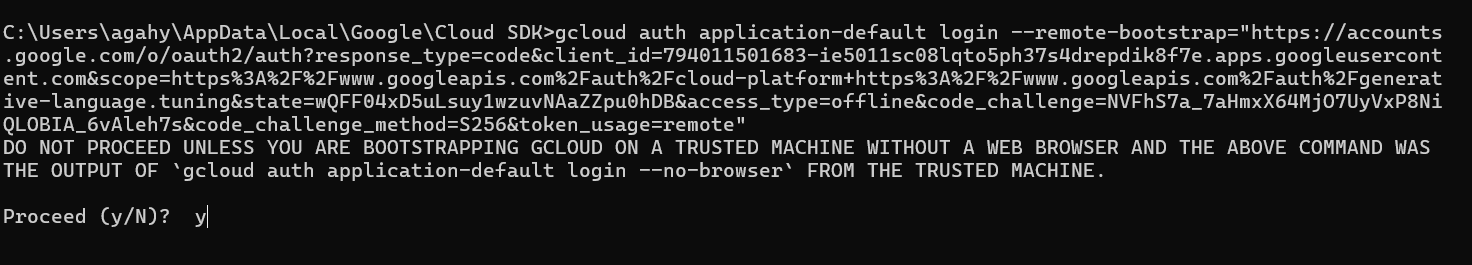

13. Select User Account and confirm all requested permissions

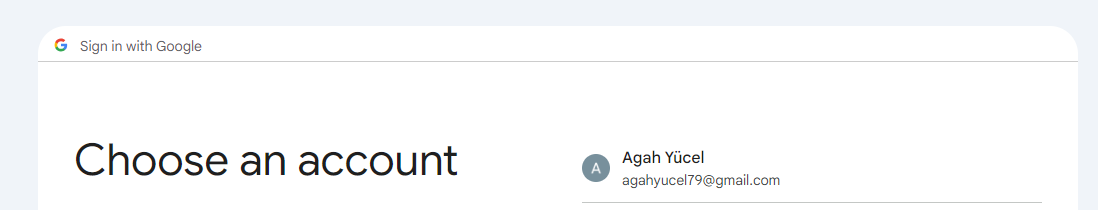

14. After the confirmations are given, copy the selected address in the SDK terminal and paste it into the empty cell next to the "Enter the output of the above command: " instruction in the colab notebook. Then click enter

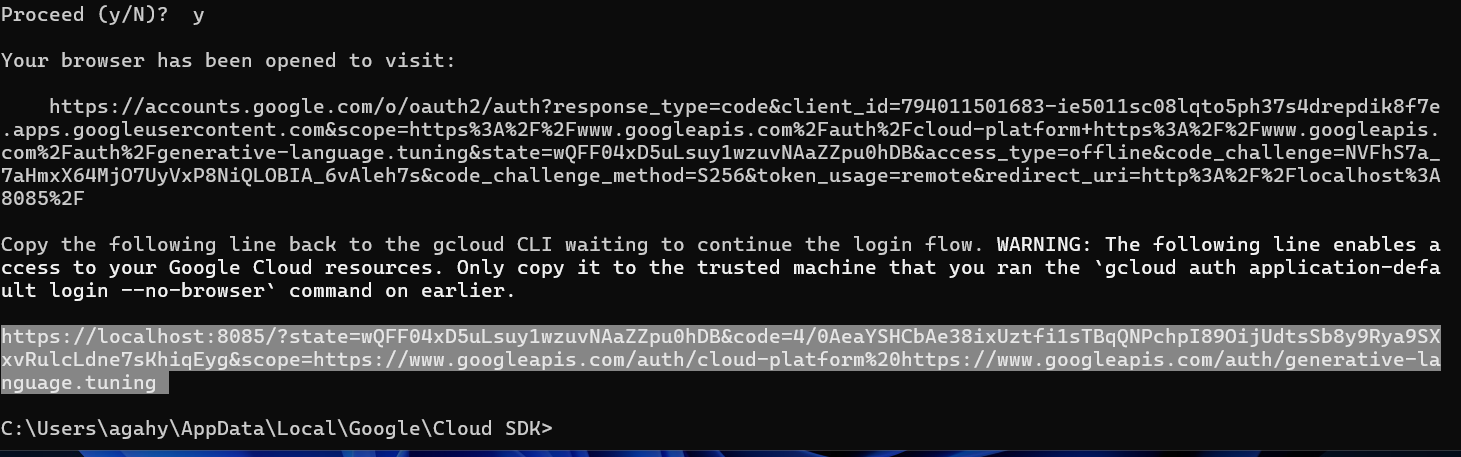

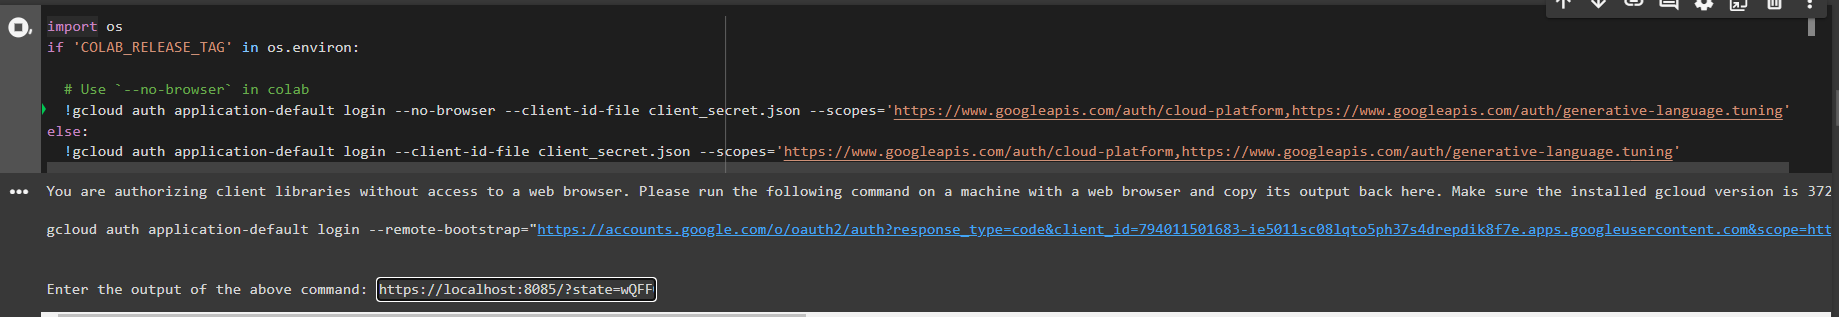

In [ ]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:

  # Use `--no-browser` in colab
  !gcloud auth application-default login --no-browser --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  !gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'

You are authorizing client libraries without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth application-default login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=794011501683-ie5011sc08lqto5ph37s4drepdik8f7e.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=0KF91j8sdArUjg1SVLV5lnMjVCUrEP&access_type=offline&code_challenge=achBPJAWl_MUPFIoPEj6yunqbrlAgCGksdzXP0m6Kxg&code_challenge_method=S256&token_usage=remote"


Enter the output of the above command: https://localhost:8085/?state=0KF91j8sdArUjg1SVLV5lnMjVCUrEP&code=4/0AeaYSHCr7ny2I6sCVjrxTieuMzpDExesNRFf_fCEeY8GrXLgI1aIpmYQashLaRD4oLOGEw&scope=https://www.googleapis.com/auth/cloud-platform%20https://www.googleapis.com/auth/generati

### Install the client library

In [ ]:
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.8/146.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.5/664.5 kB 8.0 MB/s eta 0:00:00


### Import libraries

In [ ]:
import google.generativeai as genai

print('Available base models:', [m.name for m in genai.list_models()])

Available base models: ['models/chat-bison-001', 'models/text-bison-001', 'models/embedding-gecko-001', 'models/gemini-1.0-pro', 'models/gemini-1.0-pro-001', 'models/gemini-1.0-pro-latest', 'models/gemini-1.0-pro-vision-latest', 'models/gemini-1.5-pro-latest', 'models/gemini-pro', 'models/gemini-pro-vision', 'models/embedding-001', 'models/text-embedding-004', 'models/aqa']


In [ ]:
#import google.generativeai as genai

#genai.configure()
#print('My tuned models:', [m.name for m in genai.list_tuned_models()])

In [ ]:
!gcloud --version

Google Cloud SDK 472.0.0


You can check your existing tuned models with the `genai.list_tuned_model` method.

In [ ]:
print('My tuned models:', [m.name for m in genai.list_tuned_models()])

My tuned models: ['tunedModels/generatenum2540', 'tunedModels/generatenum6950']


## Create tuned model

To create a tuned model, we need to pass your dataset to the model in the `genai.create_tuned_model` method. we can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, we will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [ ]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

Model(name='models/gemini-1.0-pro-001',
      base_model_id='',
      version='001',
      display_name='Gemini 1.0 Pro 001 (Tuning)',
      description=('The best model for scaling across a wide range of tasks. This is a stable '
                   'model that supports tuning.'),
      input_token_limit=30720,
      output_token_limit=2048,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=0.9,
      top_p=1.0,
      top_k=1)

In [ ]:
base_model.name

'models/gemini-1.0-pro-001'

In [ ]:
base_model.output_token_limit

2048

In [ ]:
prompt= ["After spending several months studying abroad in Spain, John Wick and Johnson returned home with a newfound appreciation for the Spanish language and culture.",
         "Despite the fact that I had saved up 100.000 USD, I still found it difficult to afford a house in the city.",
         "When I was a child, my grandparents would take me on long walks through the countryside, and those memories are still some of my most cherished.",
         "After years of working in the corporate world, I decided to start my own business, and I've never looked back.",
         "The ancient ruins we visited in Rome were so awe-inspiring that I found myself speechless.",
         "Despite the fact that I had been practicing for months, my piano recital was a disaster, and I was humiliated.",
         "When she traveled to Thailand, Mary was amazed by the beauty and serenity of the Buddhist temples.",
         "My grandmother's estate, which had been passed down through several generations of our family, was the site of many cherished family gatherings.",
         "When I was a student, I spent a semester studying abroad in France, and it was one of the most enriching experiences of my life.",
         "After my grandfather passed away, my family and I spent weeks going through his belongings and reminiscing about his life.",
         "The White House is located in Washington, D.C.",
         "I need to exchange dollars for euros before I travel to Europe.",
         "The exchange rate between the pound and the euro is favorable.",
         "As a child, I used to spend my summers at my grandparents' farm, and those days are some of my most cherished memories.",
         "After years of working for a multinational corporation, I decided to quit my job and travel the World.",
         "My great-grandfather fought in World War II, and his stories about the war have been passed down through the generations of our family.",
         "When I was in college, I spent a semester studying abroad in China, and it was an eye-opening experience.",
         "My best friend and I have been planning a trip to South America for years, and we're finally going to make it happen this summer.",
         "My parents own a small motel in a charming seaside town, and they've been running it for over 20 years.",
         "Johnson and I decided to take a road trip across the United States during the summer after we graduated from college."]

In [ ]:
target= [{"Person": ["John Wick", "Johnson"], "Time": "several months", "Currency": "null", "Place": "Spain"},
         {"Person": "null", "Time": "null", "Currency": "USD", "Place": "null"},
         {"Person": "null", "Time": "null", "Currency": "null", "Place": "null"},
         {"Person": "null", "Time": "years", "Currency": "null", "Place": "null"},
         {"Person": "null", "Time": "null", "Currency": "null", "Place": "Rome"},
         {"Person": "null", "Time": "months", "Currency": "null", "Place": "null"},
         {"Person": "Mary", "Time": "null", "Currency": "null", "Place": "Thailand"},
         {"Person": "null", "Time": "null", "Currency": "null", "Place": "null"},
         {"Person": "null", "Time": "semester", "Currency": "null", "Place": "France"},
         {"Person": "null", "Time": "weeks", "Currency": "null", "Place": "null"},
         {"Person": "null", "Time": "null", "Currency": "null", "Place": "Washington, D.C."},
         {"Person": "null", "Time": "null", "Currency": ["dollars", "euros"], "Place": "Europe"},
         {"Person": "null", "Time": "null", "Currency": ["pound", "euro"], "Place": "null"},
         {"Person": "null", "Time": ["summers", "those days"], "Currency": "null", "Place": "null"},
         {"Person": "null", "Time": "years", "Currency": "null", "Place": "World"},
         {"Person": "null", "Time": "null", "Currency": "null", "Place": "null"},
         {"Person": "null", "Time": "semester", "Currency": "null", "Place": "China"},
         {"Person": "null", "Time": ["years", "summer"], "Currency": "null", "Place": "South America"},
         {"Person": "null", "Time": "over 20 years", "Currency": "null", "Place": "null"},
         {"Person": "Johnson", "Time": "summer", "Currency": "null", "Place": "United States"}]

In [ ]:
#system="""Extract {labels} from {text} and return them in dict type.
#labels: 'Person (name, surname)', 'Time (this week, last month, summer, next month etc.)', 'Currency (USD, EURO, etc.)', 'Place (country, city, etc.)'.
#text: """ # text=

In [ ]:
#system="""Extract the labels delimited by angle brackets from text delimited by angle brackets and return them in dict type.
#labels: <'Person (name, surname)', 'Time (this week, last month, summer, next month etc.)', 'Currency (USD, EURO, etc.)', 'Place (country, city, etc.)'.>
#text: """

In [ ]:
system="""Extract the labels delimited by XML tags from text delimited by XML tags and return them in dict type.
<labels>'Person': <person names and surnames>, 'Time': <word or words indicating time \
like this week, last month, summer, next month etc.>', 'Currency':<all currencies like USD, EURO, etc.>, \
'Place':<settlement like country, city, district etc.> </labels>
<text>"""

# commonly used delimiters:
# triple quotes: """
# triple backticks: '''
# riple dashes: ___
# angle brackets : <>
# curly brackets: {}
# XML tags: <tag> </tag> ---> <text>This is sentence</text>

In [ ]:
def prompt_new(prompt):
  new_prompt=[system + i +'</text>' for i in prompt]
  return new_prompt

In [ ]:
new_prompt=prompt_new(prompt)

In [ ]:
new_prompt[0]

"Extract the labels delimited by XML tags from text delimited by XML tags and return them in dict type.\n<labels>'Person': <person names and surnames>, 'Time': <word or words indicating time like this week, last month, summer, next month etc.>', 'Currency':<all currencies like USD, EURO, etc.>, 'Place':<settlement like country, city, district etc.> </labels>\n<text>After spending several months studying abroad in Spain, John Wick and Johnson returned home with a newfound appreciation for the Spanish language and culture.</text>"

In [ ]:
import pandas as pd
my_dict={"text_input":new_prompt, "output":target}
df=pd.DataFrame(my_dict)
df

,text_input,output
0,Extract the labels delimited by XML tags from ...,"{'Person': ['John Wick', 'Johnson'], 'Time': '..."
1,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'null', 'Currency':..."
2,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'null', 'Currency':..."
3,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'years', 'Currency'..."
4,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'null', 'Currency':..."
5,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'months', 'Currency..."
6,Extract the labels delimited by XML tags from ...,"{'Person': 'Mary', 'Time': 'null', 'Currency':..."
7,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'null', 'Currency':..."
8,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'semester', 'Curren..."
9,Extract the labels delimited by XML tags from ...,"{'Person': 'null', 'Time': 'weeks', 'Currency'..."


In [ ]:
df.to_csv("data.csv")

In [ ]:
import random

name = f'generatenum{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # we can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    description='NER_person_time',
    display_name=name,
    id=name,
    training_data="/content/data.csv",
    epoch_count=20,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [ ]:
name

'generatenum5339'

In [ ]:
models=[m.name for m in genai.list_tuned_models()]
models

['tunedModels/generatenum2540',
 'tunedModels/generatenum6950',
 'tunedModels/generatenum5339']

In [ ]:
models[-1]

'tunedModels/generatenum5339'

In [ ]:
model = genai.get_tuned_model(f"tunedModels/{name}") #models[-1]

model

TunedModel(name='tunedModels/generatenum5339',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='generatenum5339',
           description='NER_person_time',
           temperature=0.9,
           top_p=1.0,
           top_k=1,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 4, 23, 17, 9, 34, 303067, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 4, 23, 17, 10, 54, 784726, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 4, 23, 17, 9, 35, 4021, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 4, 23, 17, 10, 54, 784726, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=20,
                                                              

In [ ]:
model.name

'tunedModels/generatenum5339'

In [ ]:
model.state

<State.ACTIVE: 2>

### Check tuning progress

Use `metadata` to check the state:

In [ ]:
operation.metadata

total_steps: 100
tuned_model: "tunedModels/generatenum5339"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
operation.result()

TunedModel(name='tunedModels/generatenum5339',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='generatenum5339',
           description='NER_person_time',
           temperature=0.9,
           top_p=1.0,
           top_k=1,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 4, 23, 17, 9, 34, 303067, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 4, 23, 17, 10, 54, 784726, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 4, 23, 17, 9, 35, 4021, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 4, 23, 17, 10, 54, 784726, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=20,
                                                              

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
#operation.cancel()

Once the tuning is complete, we can view the loss curve from the tuning results. The [loss curve](https://generativeai.devsite.corp.google.com/guide/model_tuning_guidance#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

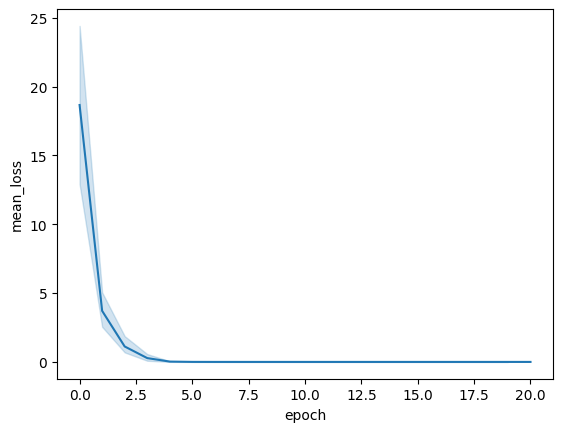

In [ ]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss');


In [ ]:
snapshots

,step,mean_loss,epoch,compute_time
0,1,2.682976e+01,0,2024-04-23 17:09:36.724444+00:00
1,2,2.199494e+01,0,2024-04-23 17:09:37.530408+00:00
2,3,1.587884e+01,0,2024-04-23 17:09:38.180492+00:00
3,4,9.960492e+00,0,2024-04-23 17:09:38.962215+00:00
4,5,6.284337e+00,1,2024-04-23 17:09:39.646241+00:00
...,...,...,...,...
95,96,-9.378768e-06,19,2024-04-23 17:10:51.789412+00:00
96,97,-7.913914e-07,19,2024-04-23 17:10:52.350524+00:00
97,98,5.239150e-06,19,2024-04-23 17:10:52.987047+00:00
98,99,-2.947520e-06,19,2024-04-23 17:10:53.722995+00:00


## Evaluate your model

You can use the `genai.generate_text` method and specify the name of your model to test your model performance.

In [ ]:
model2 = genai.GenerativeModel(model_name=model.name)

In [ ]:
model.name

'tunedModels/generatenum5339'

In [ ]:
system

"Extract the labels delimited by XML tags from text delimited by XML tags and return them in dict type.\n<labels>'Person': <person names and surnames>, 'Time': <word or words indicating time like this week, last month, summer, next month etc.>', 'Currency':<all currencies like USD, EURO, etc.>, 'Place':<settlement like country, city, district etc.> </labels>\n<text>"

In [ ]:
text1="While I was on summer vacation in Turkey, Joseph earned 100 dollars, 100 euros in Germany and London."

In [ ]:
prompt1=prompt_new([text1])
prompt1

["Extract the labels delimited by XML tags from text delimited by XML tags and return them in dict type.\n<labels>'Person': <person names and surnames>, 'Time': <word or words indicating time like this week, last month, summer, next month etc.>', 'Currency':<all currencies like USD, EURO, etc.>, 'Place':<settlement like country, city, district etc.> </labels>\n<text>While I was on summer vacation in Turkey, Joseph earned 100 dollars, 100 euros in Germany and London.</text>"]

In [ ]:
result = model2.generate_content(prompt1)
result.text

"{'Person': 'Joseph', 'Time': 'summer', 'Currency': ['dollars', 'euros'], 'Place': ['Turkey', 'Germany', 'London']}"

In [ ]:
text2="My grandmother was a talented seamstress, and she taught me how to sew when I was young, which sparked a lifelong passion for fashion and design."

In [ ]:
prompt2=prompt_new([text2])
result = model2.generate_content(prompt2)
result.text


"{'Person': 'null', 'Time': 'null', 'Currency': 'null', 'Place': 'null'}"

In [ ]:
text3="Johnson Walker and Maria got married last month. They bought a house in London for 100,000 sterling pounds."

In [ ]:
prompt3=prompt_new([text3])
result = model2.generate_content(prompt3)
result.text

"{'Person': ['Johnson Walker', 'Maria'], 'Time': 'last month', 'Currency': 'sterling pounds', 'Place': 'London'}"

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/docs/model_tuning_guidance) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [ ]:
genai.update_tuned_model(f'{model.name}', {"description":"This is my model."});

In [ ]:
genai.update_tuned_model()

In [ ]:
model3 = genai.get_tuned_model(f'{model.name}')

model3.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [ ]:
genai.delete_tuned_model(f'{model.name}')

The model no longer exists:

In [ ]:
try:
  m = genai.get_tuned_model(f'{model.name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 Tuned model tunedModels/generatenum5413-k1v8gczj7zz3 does not exist.


END OF THE PROJECT